In [1]:
import numpy as np
import pandas as pd
import scipy as sp

from tqdm import tqdm, trange
import io
import random
import os
from functools import partial
import copy

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torchnlp.encoders.text import StaticTokenizerEncoder, stack_and_pad_tensors, pad_tensor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import cohen_kappa_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
torch.set_default_dtype(torch.float64)
sns.set()

In [4]:
DEVICE = torch.device("cuda")
EPOCHS = 20
BATCH_SIZE = 512
LEARN_RATE = 1e-2

# Read data

In [5]:
INPUT_PATH = 'data/input'
FILENAME = 'tripadvisor_hotel_reviews.csv'

In [6]:
df = pd.read_csv(f'{INPUT_PATH}/{FILENAME}')
print(df.shape)
df.sample(5)

(20491, 2)


,Review,Rating
10726,not recommend hotel did reviewers actually sta...,1
14919,"barcelona rocks, stayed hotel jazz girlfriend ...",4
19098,ok hotel good location stayed night way beijin...,3
2450,great service nice pool ok beach lovely ground...,4
960,surprising treat spent weekend july 15/16 2006...,5


In [7]:
df['Review'].str.split().apply(lambda x: len(x)).describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Review, dtype: float64

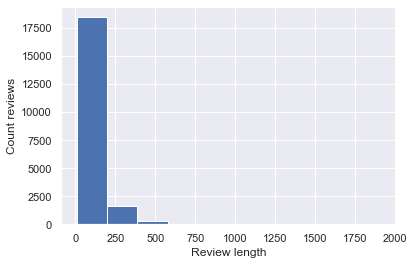

In [36]:
df['Review'].str.split().apply(lambda x: len(x)).hist()
plt.xlabel('Review length')
plt.ylabel('Count reviews')
plt.savefig('img/words_hist.jpg', dpi = 600)

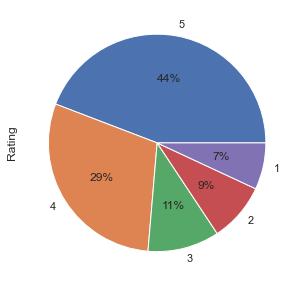

In [9]:
df['Rating'].value_counts().plot.pie(y='Rating', figsize=(5, 5), autopct='%1.0f%%')
plt.savefig('img/pie.jpg', dpi = 600)

# Preprocess

In [10]:
df['Review'] = df['Review'].str.replace('[^\w\s]','') # remove punctuation marks
df['Review'] =  df['Review'].str.replace('\d+', '') # remove numbers

# Train/validation/test split

In [11]:
test_size = 0.1
X, y = df['Review'], df['Rating']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = test_size, stratify = y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = test_size * (1-test_size), stratify = y_tr, shuffle=True) 

# Tokenization

In [12]:
def tokenize(encoder, X, padding = 2000):
    encoded_X = [encoder.encode(x) for x in X]
    encoded_X = [pad_tensor(x, length=padding) for x in encoded_X]
    return stack_and_pad_tensors(encoded_X).tensor
    
encoder = StaticTokenizerEncoder(X_train.values, tokenize=lambda s: s.split())
X_train = tokenize(encoder, X_train.values)
X_val = tokenize(encoder, X_val.values)
X_test = tokenize(encoder, X_test.values)

In [13]:
encoder.vocab_size

67354

In [14]:
X_train.size(1)

2000

# Create dataloaders for torch model

In [15]:
train_dataset = TensorDataset(X_train, torch.tensor(y_train.values))
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)

val_dataset = TensorDataset(X_val, torch.tensor(y_val.values))
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=BATCH_SIZE)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=BATCH_SIZE,)

# Model

In [16]:
vocab_size = encoder.vocab_size
embedding_size = 100
seq_len = 2000
rnn_size = 32
hidden_size = 16
output_size = 1

class ReviewsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, rnn_size)
        self.drop1 = nn.Dropout(0.5)
        self.norm1 = nn.BatchNorm1d(seq_len*rnn_size)
        self.fc1 = nn.Linear(seq_len*rnn_size, hidden_size)
        self.drop2 = nn.Dropout(0.5)
        self.norm2 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.out = nn.ReLU()
        

    def forward(self, inputs):
        batch_size = inputs.size(0)
        emb = self.emb(inputs)
        
        self.rnn.flatten_parameters()
        rnn, hid = self.rnn(emb)
        rnn = self.drop1(rnn)
        a1 = self.fc1(self.norm1(rnn.view(batch_size, -1)))
        a1 = self.drop2(a1)
        a2 = self.fc2(self.norm2(a1))
        return self.out(a2).float().squeeze()

# Train model

In [17]:
def round_output(y, thresh = [1.5, 2.5, 3.5, 4.5], labels = [1, 2, 3, 4, 5]):
    return pd.cut(y, bins = [-np.inf, *thresh, np.inf], labels = labels).astype(int)

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = .0
    running_kappa = .0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        y_pred = round_output(outputs.data.cpu().numpy())

        loss = criterion(outputs, labels.float())
        kappa = cohen_kappa_score(y_pred, labels.data.cpu().numpy(), weights='quadratic')
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_kappa += kappa * inputs.size(0)
        processed_data += inputs.size(0)
        
        
    train_loss = running_loss / processed_data
    train_kappa = running_kappa / processed_data
    return train_loss, train_kappa

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = .0
    running_kappa = .0
    processed_data = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            y_pred = round_output(outputs.data.cpu().numpy())
            loss = criterion(outputs, labels.float())
            kappa = cohen_kappa_score(y_pred, labels.data.cpu().numpy(), weights='quadratic')

        
        running_loss += loss.item() * inputs.size(0)
        running_kappa += kappa * inputs.size(0)
        processed_data += inputs.size(0)
        
        
    val_loss = running_loss / processed_data
    val_kappa = running_kappa / processed_data
    return val_loss, val_kappa

In [19]:
model = ReviewsModel().to(DEVICE)
print(model)

ReviewsModel(
  (emb): Embedding(67354, 100)
  (rnn): LSTM(100, 32)
  (drop1): Dropout(p=0.5, inplace=False)
  (norm1): BatchNorm1d(64000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64000, out_features=16, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (out): ReLU()
)


In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), LEARN_RATE, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')

In [21]:
verbose =1

log_template = "\n[{ep:03d}/{epochs:03d}] train_loss: {t_loss:0.4f} train_kappa: {t_kappa:.4f} \
val_loss {v_loss:0.4f} val_kappa: {v_kappa:.4f}"
history = []

#early stopping params
kappa_best = -1
stop_counter = 0
patience = 15
delta = 0.005

for epoch in range(EPOCHS):
    train_loss, train_kappa = fit_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_kappa = eval_epoch(model, val_loader, criterion)
    scheduler.step(val_kappa)
    
    history.append([train_loss, train_kappa, val_loss, val_kappa])

    log = log_template.format(ep=epoch+1,epochs =EPOCHS, t_loss=train_loss, t_kappa=train_kappa,\
                                   v_loss=val_loss, v_kappa= val_kappa)
    
    # early stopping
    if val_kappa > kappa_best * (1+delta):
        kappa_best = val_kappa
        stop_counter = 0
        # best model
        best_model = copy.deepcopy(model)
    else:
        stop_counter += 1
        if stop_counter >= patience:
            print('EARLY STOP.')
            print(log)
            break
    
    # verbose
    if epoch == 0 or (epoch+1)% verbose == 0 or epoch==EPOCHS-1:
        print(log)


[001/020] train_loss: 7.9814 train_kappa: 0.0417 val_loss 5.9946 val_kappa: 0.0397

[002/020] train_loss: 2.9836 train_kappa: 0.1364 val_loss 1.7213 val_kappa: 0.0777

[003/020] train_loss: 1.7308 train_kappa: 0.3486 val_loss 2.4508 val_kappa: 0.1400

[004/020] train_loss: 1.4813 train_kappa: 0.4186 val_loss 1.8502 val_kappa: 0.2729

[005/020] train_loss: 1.3201 train_kappa: 0.4806 val_loss 2.1552 val_kappa: 0.2372

[006/020] train_loss: 1.2156 train_kappa: 0.5216 val_loss 1.0507 val_kappa: 0.4879

[007/020] train_loss: 1.1032 train_kappa: 0.5646 val_loss 0.9736 val_kappa: 0.5252

[008/020] train_loss: 1.0221 train_kappa: 0.5982 val_loss 0.8522 val_kappa: 0.5429

[009/020] train_loss: 0.9069 train_kappa: 0.6249 val_loss 0.6934 val_kappa: 0.6533

[010/020] train_loss: 0.7430 train_kappa: 0.6551 val_loss 0.8209 val_kappa: 0.5757

[011/020] train_loss: 0.7286 train_kappa: 0.6608 val_loss 0.6440 val_kappa: 0.6791

[012/020] train_loss: 0.7218 train_kappa: 0.6674 val_loss 0.9296 val_kappa:

In [41]:
history = list(zip(*history))

In [62]:
def plot_metric(train, val, metric_name, save=True):
    plt.plot(train, label = f'train {metric_name}')
    plt.plot(val, label = f'val {metric_name}')
    plt.xticks(range(len(history[0])))
    plt.ylim(bottom=0)
    plt.legend()
    if save:
        plt.savefig(f'img/{metric_name}.jpg', dpi=600)
    plt.show()
    plt.close()

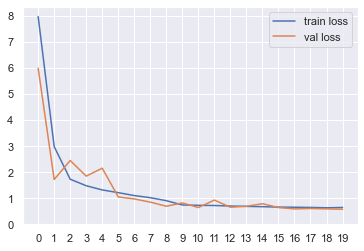

In [63]:
plot_metric(history[0], history[2], 'loss')

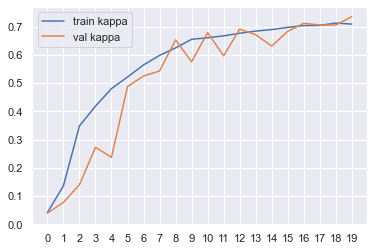

In [64]:
plot_metric(history[1], history[3], 'kappa')

In [25]:
model = copy.deepcopy(best_model)
del best_model

# Evalute model

In [26]:
def predict(model, test_loader):
    model.eval()
    logits = []
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    return torch.cat(logits, 0).numpy()

In [27]:
train_dataset = TensorDataset(X_train, torch.tensor(y_train.values))
train_loader = DataLoader(train_dataset,shuffle=False,batch_size=BATCH_SIZE)

## Scores without optimized thresholds

In [28]:
y_train_hat = predict(model, train_loader)

y_val_hat = predict(model, val_loader)

y_test_hat = predict(model, test_loader)

In [29]:
print('Quadratic Weighted Kappa')
print('Train: ', cohen_kappa_score(
    round_output(y_train_hat), y_train, weights = 'quadratic'))

print('Validation: ', cohen_kappa_score(
    round_output(y_val_hat), y_val, weights = 'quadratic'))

print('Test: ', cohen_kappa_score(
    round_output(y_test_hat), y_test, weights = 'quadratic'))

Quadratic Weighted Kappa
Train:  0.7935055220295901
Validation:  0.7363655418887651
Test:  0.7475972431781999


## Scores with optimized thresholds

In [30]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, y_hat, y):
        preds = pd.cut(y_hat, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [1, 2, 3, 4, 5]).astype(int)
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, y_hat, y, initial_coef = [1.5, 2.5, 3.5, 4.5]):
        loss_partial = partial(self._kappa_loss, y_hat = y_hat, y = y)
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')['x']
    
    def predict(self, y_hat, coef):
        preds = pd.cut(y_hat, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [1, 2, 3, 4, 5]).astype(int)
        return preds

In [31]:
rounder = OptimizedRounder()
rounder.fit(y_train_hat, y_train)

In [32]:
coefs = rounder.coef_
coefs

array([1.61543239, 2.84956807, 3.41715743, 4.17203765])

In [33]:
print('Quadratic Weighted Kappa')
print('Train: ', cohen_kappa_score(
    rounder.predict(y_train_hat, coefs), y_train, weights = 'quadratic'))

print('Validation: ', cohen_kappa_score(
    rounder.predict(y_val_hat, coefs), y_val, weights = 'quadratic'))

print('Test: ', cohen_kappa_score(
    rounder.predict(y_test_hat, coefs), y_test, weights = 'quadratic'))

Quadratic Weighted Kappa
Train:  0.8337437228496121
Validation:  0.7847195435016826
Test:  0.7858499948856452


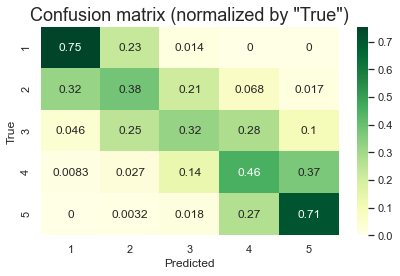

In [66]:
labels=[1,2,3,4,5]
sns.heatmap(confusion_matrix(rounder.predict(y_test_hat, coefs), y_test, normalize='true'), xticklabels=labels, yticklabels = labels, annot=True, cmap = 'YlGn')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion matrix (normalized by "True")', fontsize=18)
plt.tight_layout()
plt.savefig('img/conf_matrix.jpg', dpi = 600)